In [1]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class CustomPlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            class_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),           
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])


In [3]:
from torch.utils.data import DataLoader

batch_size = 32

train_dataset = CustomPlantDiseaseDataset(root_dir='../data/New Plant Diseases Dataset(Augmented)/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = CustomPlantDiseaseDataset(root_dir='../data/New Plant Diseases Dataset(Augmented)/valid', transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)


In [4]:
import matplotlib.pyplot as plt
from torchvision import utils

classes = train_dataset.classes

print(len(classes))


38


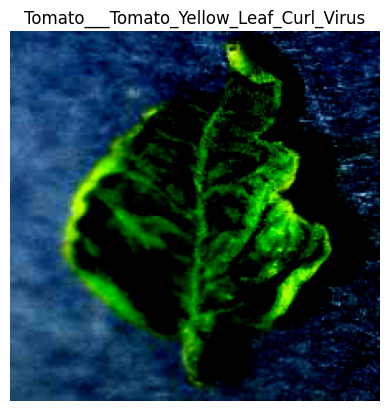

(224, 224, 3) 22


In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np

random_idx = random.randint(0, len(train_dataset) - 1)

image, label = train_dataset[random_idx]

classes = train_dataset.classes

image_np = image.permute(1, 2, 0).numpy()

image_np = np.clip(image_np, 0, 1)

plt.imshow(image_np)
plt.title(classes[label])
plt.axis('off')
plt.show()

print(image_np.shape, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


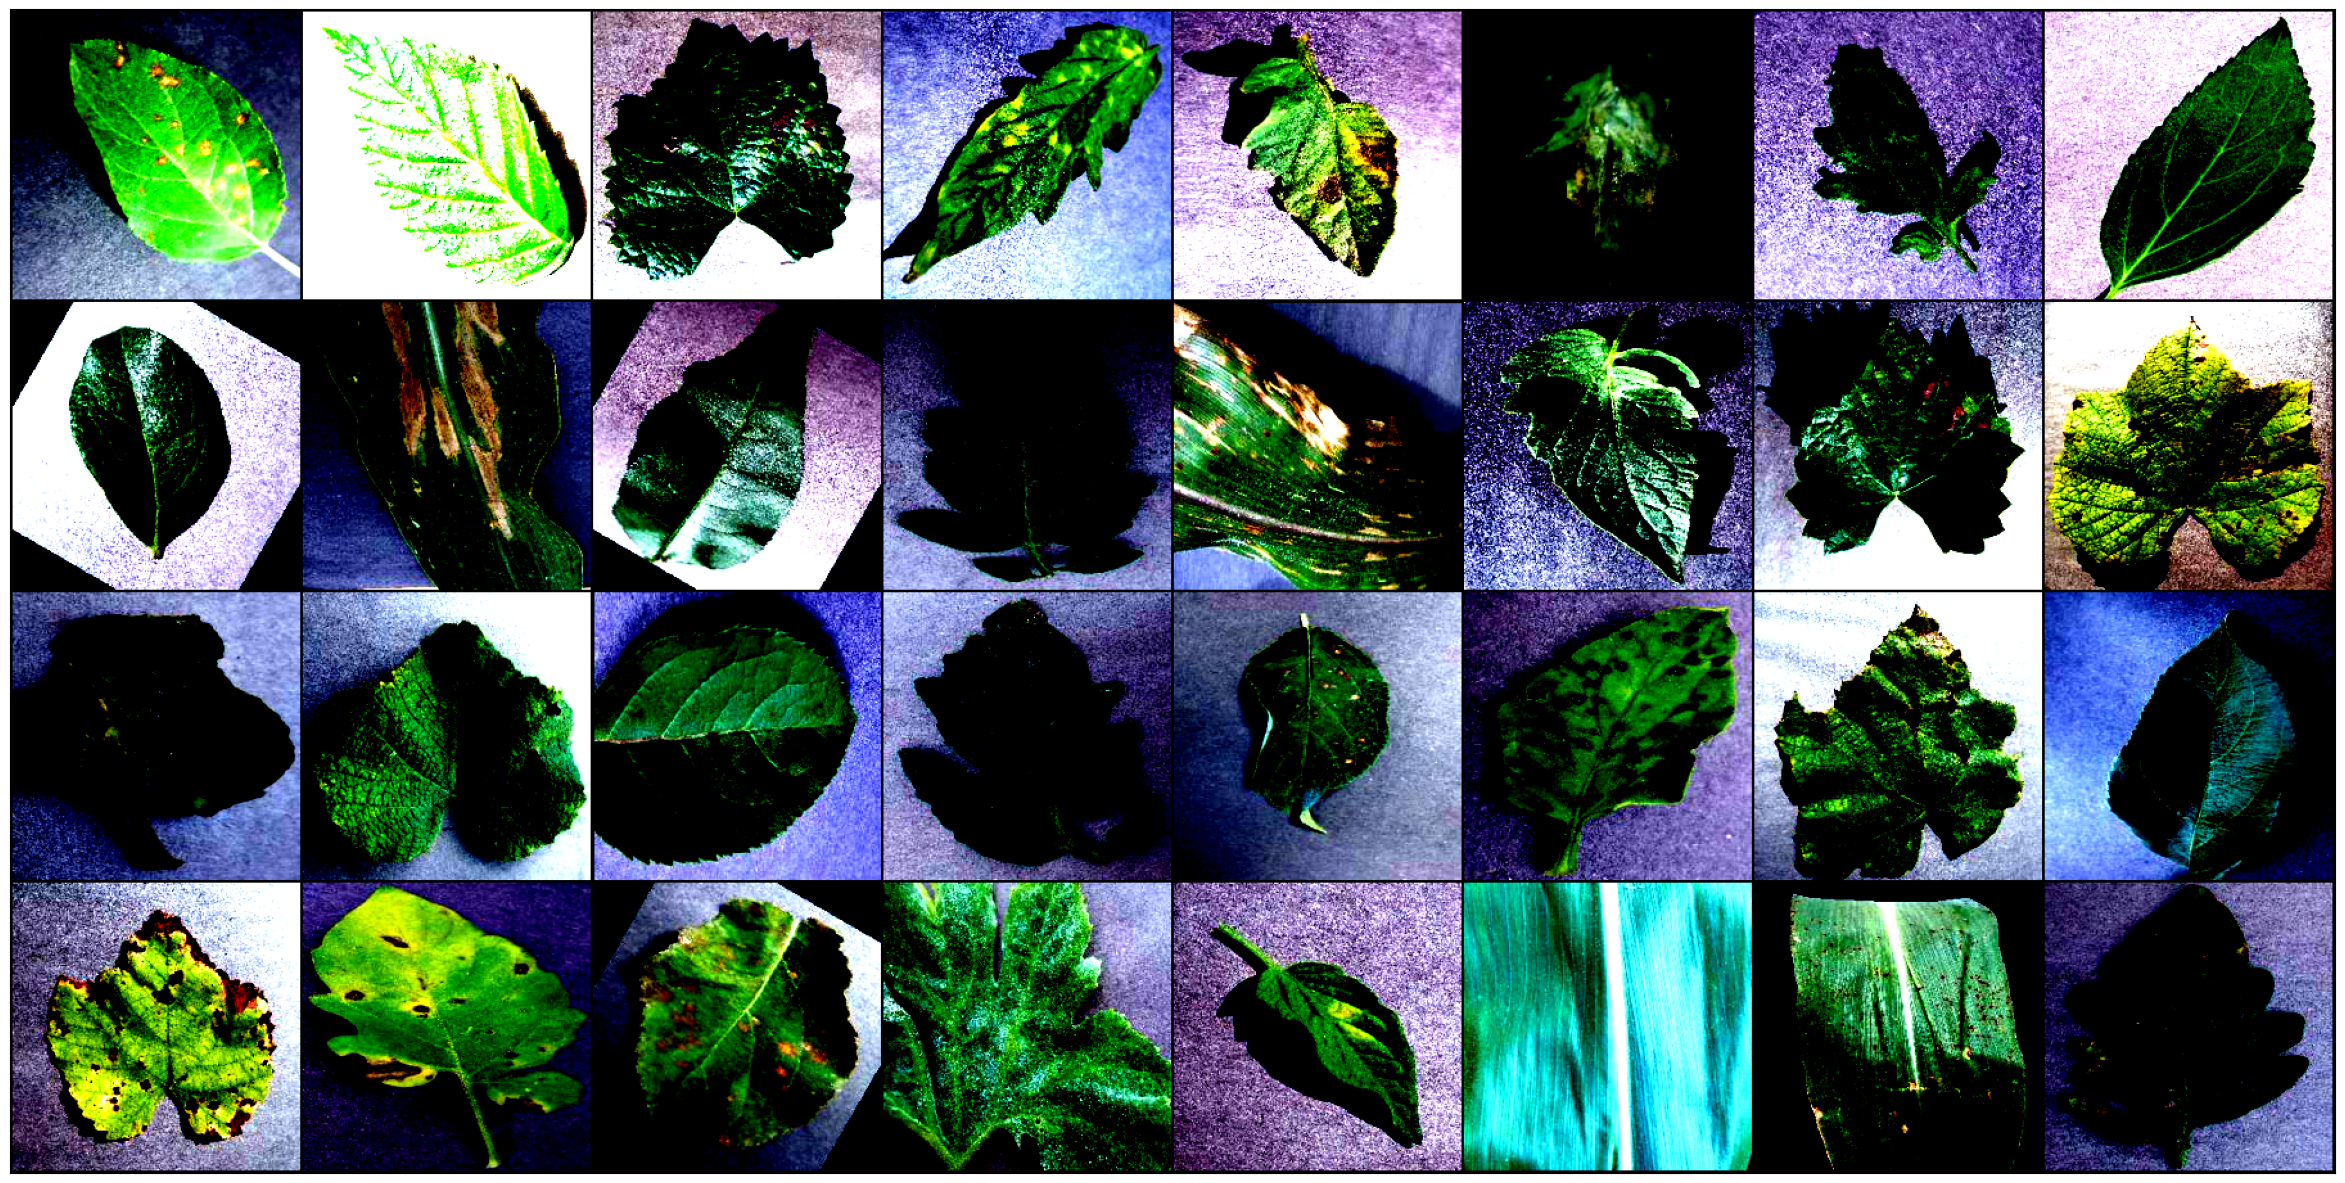

In [6]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(utils.make_grid(images, nrow=8).permute(1, 2, 0))
        plt.show()
        break  

show_batch(train_loader)

In [7]:
plants = []
diseases = 0
for plant in classes:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        diseases += 1

In [8]:
print(diseases)

26


In [9]:
print(len(plants))

14


In [10]:
import pandas as pd
nums = {}

for idx in range(len(train_dataset)):
    _, label = train_dataset[idx]  
    class_name = train_dataset.classes[label]
    nums[class_name] = nums.get(class_name, 0) + 1

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
print(img_per_class)

                                                    no. of images
Potato___Early_blight                                        1939
Apple___Black_rot                                            1987
Squash___Powdery_mildew                                      1736
Pepper,_bell___Bacterial_spot                                1913
Cherry_(including_sour)___Powdery_mildew                     1683
Tomato___Spider_mites Two-spotted_spider_mite                1741
Tomato___Target_Spot                                         1827
Pepper,_bell___healthy                                       1988
Raspberry___healthy                                          1781
Grape___Esca_(Black_Measles)                                 1920
Apple___Cedar_apple_rust                                     1760
Tomato___Tomato_mosaic_virus                                 1790
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Tomato___Late_blight                                         1851
Tomato___B

Text(0.5, 1.0, 'Images per each class of plant disease')

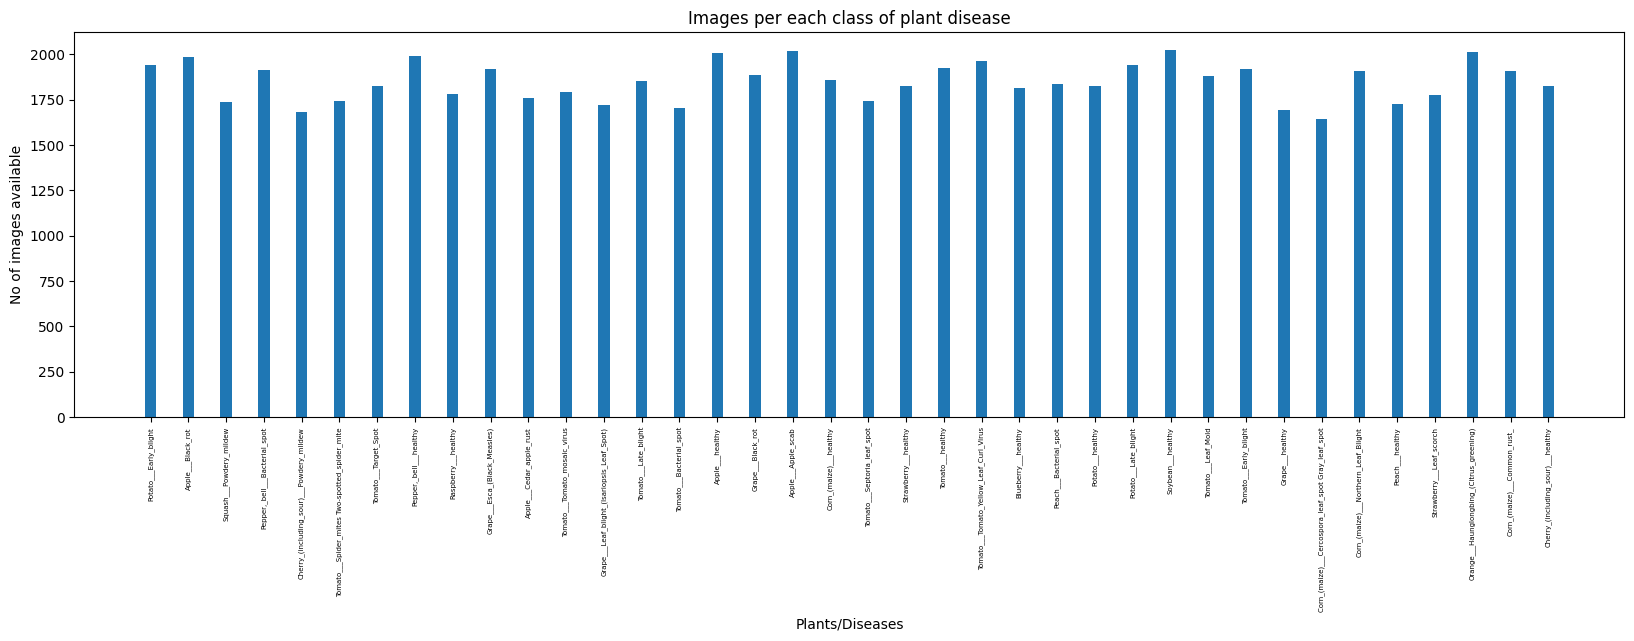

In [11]:
index = [n for n in range(38)]

plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)

plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, classes, fontsize=5, rotation=90)

plt.title('Images per each class of plant disease')

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels,kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        shortcut = self.shortcut(x)

        out += shortcut
        out = self.relu(out)
        return out


In [14]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes, num_blocks=3):
        super(CustomResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.res_blocks = nn.Sequential(*[ResidualBlock(64, 64) for _ in range(num_blocks)])

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.res_blocks(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x


In [15]:
import torch.optim as optim

learning_rate = 0.001
model = CustomResNet(num_classes=38).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [16]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    validation_loss = running_loss / len(dataloader)
    accuracy = (correct_predictions / total_samples) * 100

    return validation_loss, accuracy


In [17]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    train_accuracy = (correct_predictions / total_samples) * 100
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = evaluate_model(model, valid_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {train_loss:.4f} - Training Accuracy: {train_accuracy:.2f}% - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/10] - Loss: 1.0878 - Training Accuracy: 69.74% - Validation Loss: 0.6620 - Validation Accuracy: 79.86%
Epoch [2/10] - Loss: 0.4568 - Training Accuracy: 86.30% - Validation Loss: 0.4047 - Validation Accuracy: 87.26%
Epoch [3/10] - Loss: 0.3156 - Training Accuracy: 90.22% - Validation Loss: 0.2930 - Validation Accuracy: 90.52%
Epoch [4/10] - Loss: 0.2407 - Training Accuracy: 92.47% - Validation Loss: 0.1982 - Validation Accuracy: 93.62%
Epoch [5/10] - Loss: 0.1897 - Training Accuracy: 94.06% - Validation Loss: 0.1739 - Validation Accuracy: 94.38%
Epoch [6/10] - Loss: 0.1573 - Training Accuracy: 95.08% - Validation Loss: 0.1218 - Validation Accuracy: 96.34%
Epoch [7/10] - Loss: 0.1383 - Training Accuracy: 95.61% - Validation Loss: 0.1723 - Validation Accuracy: 94.58%
Epoch [8/10] - Loss: 0.1228 - Training Accuracy: 96.08% - Validation Loss: 0.0977 - Validation Accuracy: 96.96%
Epoch [9/10] - Loss: 0.1082 - Training Accuracy: 96.55% - Validation Loss: 0.0998 - Validation Accuracy:

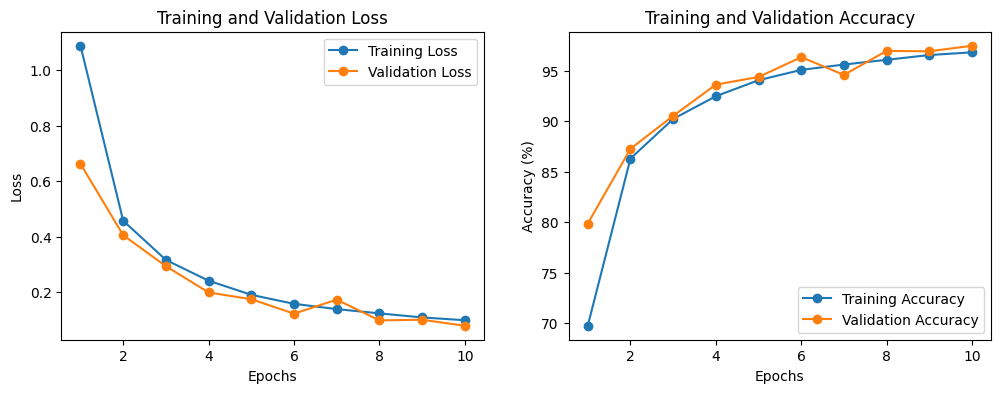

In [18]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [19]:
torch.save(model.state_dict(), '../models/custom_resnet_model2.pth')


In [20]:
def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return classes[preds[0].item()]

In [21]:
from torchvision.datasets import ImageFolder

test_dir = '../test'
test = ImageFolder(test_dir, transform=transform)
test_images = sorted(os.listdir(test_dir + '/test'))

In [22]:
for i, (img, label) in enumerate(test):
    print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

Label: AppleCedarRust1.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust2.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust3.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleCedarRust4.JPG , Predicted: Apple___Cedar_apple_rust
Label: AppleScab1.JPG , Predicted: Apple___Apple_scab
Label: AppleScab2.JPG , Predicted: Apple___Apple_scab
Label: AppleScab3.JPG , Predicted: Apple___Apple_scab
Label: CornCommonRust1.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust2.JPG , Predicted: Corn_(maize)___Common_rust_
Label: CornCommonRust3.JPG , Predicted: Corn_(maize)___Common_rust_
Label: PotatoEarlyBlight1.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight2.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight3.JPG , Predicted: Soybean___healthy
Label: PotatoEarlyBlight4.JPG , Predicted: Potato___Early_blight
Label: PotatoEarlyBlight5.JPG , Predicted: Potato___Early_blight
Label: PotatoHealthy1.JPG , Predicted: Potato___healt